In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
Yield = pd.read_csv('../data/BAMLH0A0HYM2.csv', na_values='.') # Daily since 1996
Yield.dropna(inplace=True)
Yield.index = pd.DatetimeIndex(Yield['DATE'])

df = Yield.groupby(pd.Grouper(freq="M")).mean().loc['2001-07-01':'2021-07-01']
df = df.reset_index()

SP500 = pd.read_csv('../data/SP500.csv') #since 1871
SP500['log_sp500_return'] = np.log(SP500['SP500']) - np.log(SP500['SP500'].shift()) # use log returns
SP500 = SP500[('2001-07-01' <= SP500['DATE']) & (SP500['DATE'] < '2021-07-01')]
SP500.reset_index(drop=True, inplace=True)

In [3]:
X = sm.add_constant(df.index)
Y = df['BAMLH0A0HYM2']

rols_1 = RollingOLS(Y, X, window=4)
rres = rols_1.fit()
res_1 = (rres.params['x1'] > 0) #& (rres.pvalues[:,1] < 0.05)

rols_2 = RollingOLS(Y, X, window=3) 
rres = rols_2.fit()
res_2 = (rres.params['x1'] > 0) #& (rres.pvalues[:,1] < 0.05)

res = res_1  #res_1 & ~res_2 

3.5190252812487004
3.338003728204513


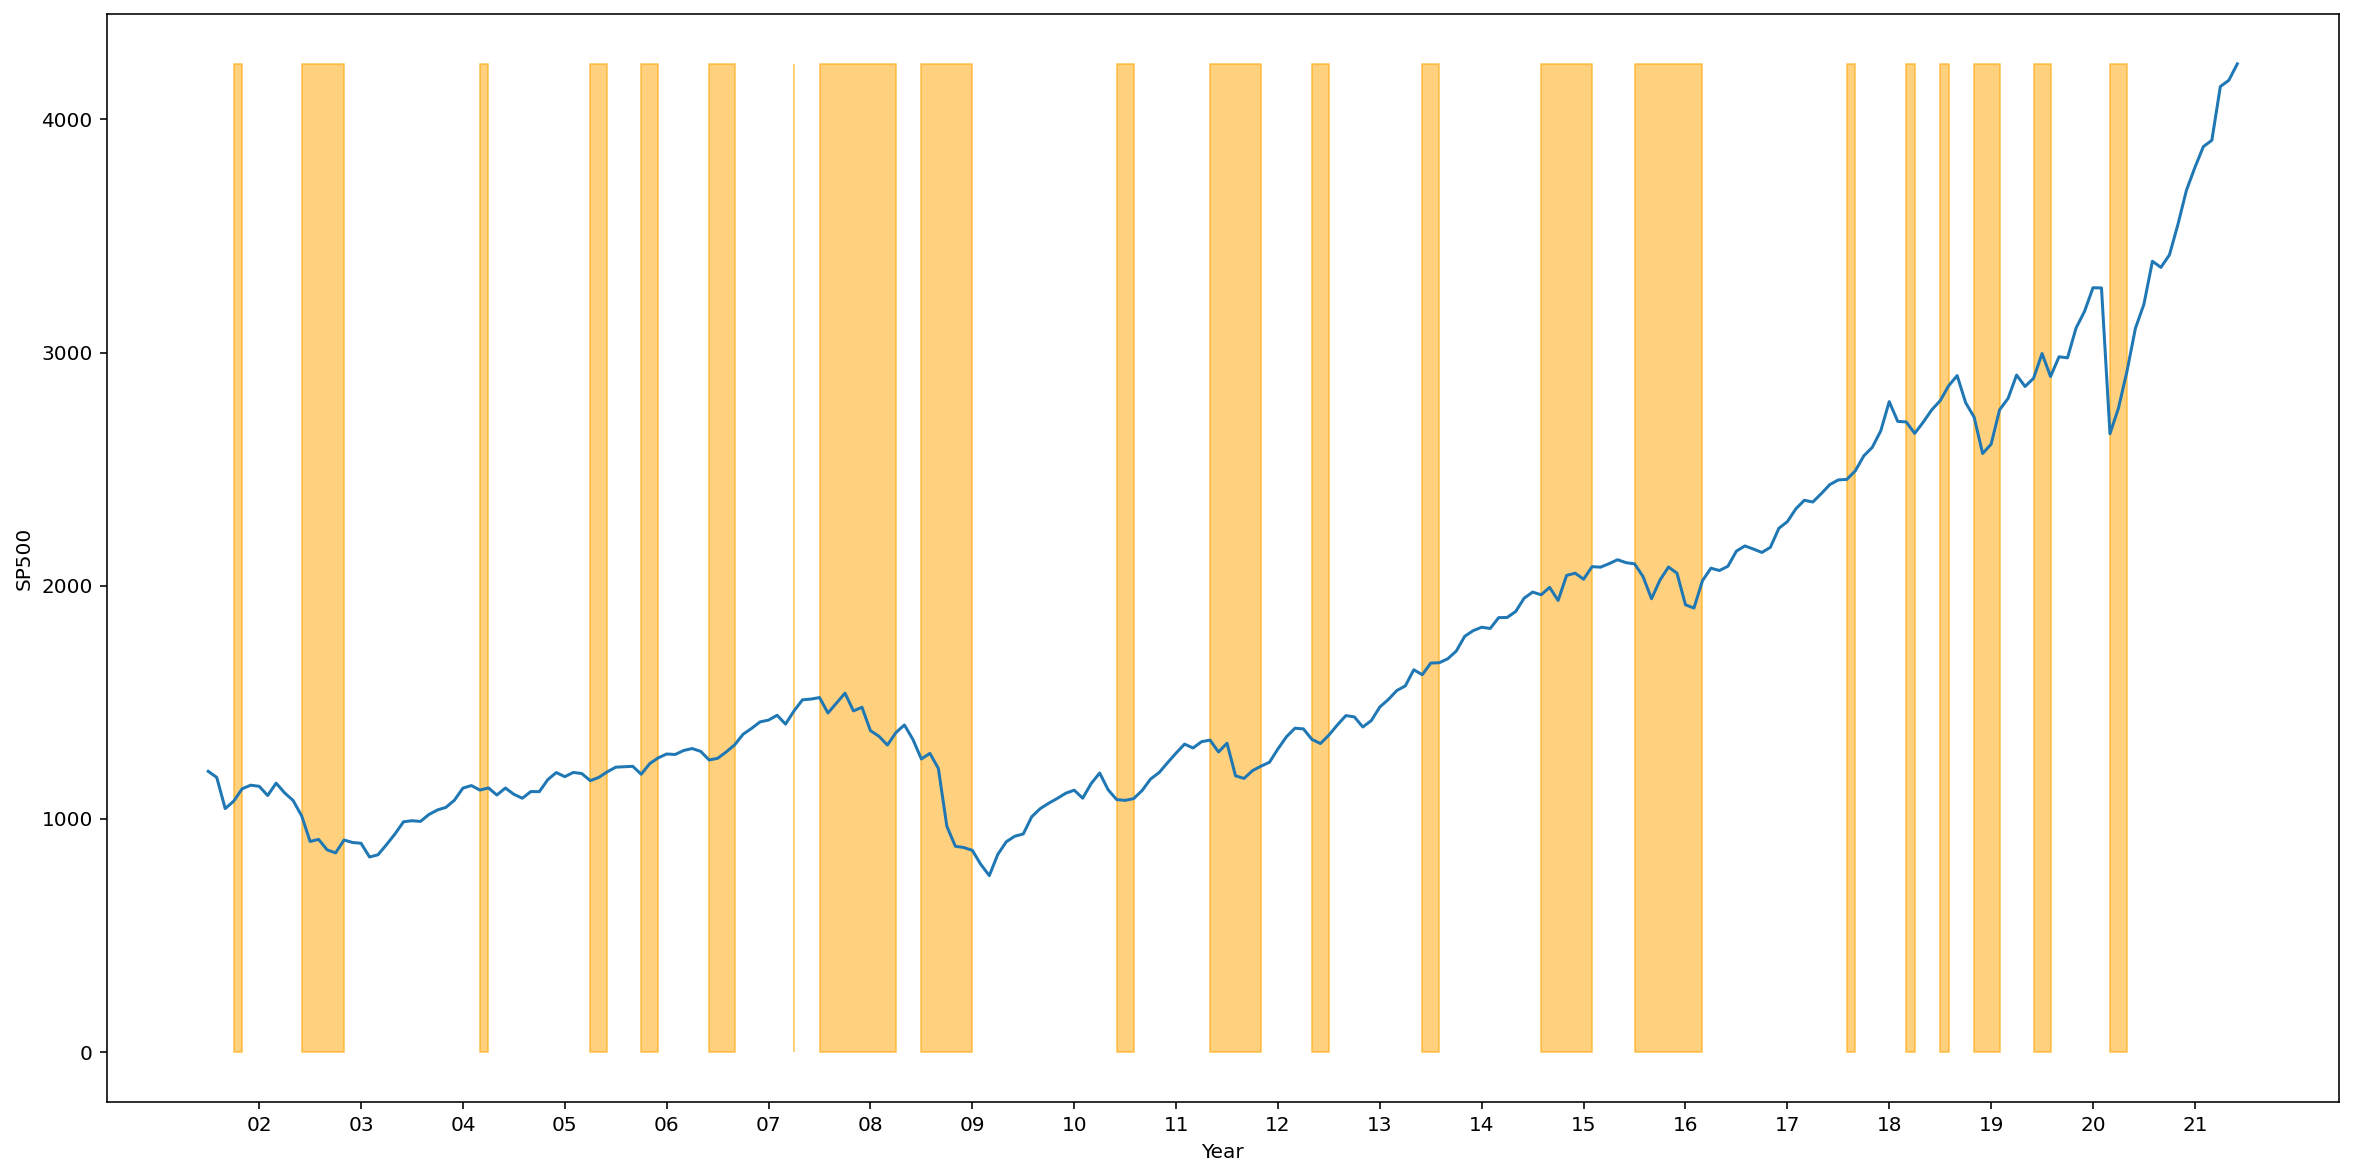

In [4]:
plt.figure(figsize=(20,10))
labels = [_[2:4] for _ in SP500['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(SP500['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('SP500')
plt.plot(SP500['DATE'], SP500['SP500'])
plt.fill_between(SP500['DATE'], np.max(SP500['SP500']), where=res, color='orange', alpha=0.5)

# Pure S&P holding log return
print(np.exp(np.log(SP500['SP500'].iloc[-1]) - np.log(SP500['SP500'].iloc[0])))
# Hold stock only when last month is not bear
hold = ~res.shift(1, fill_value=False)
print(np.exp((SP500['log_sp500_return'] * hold).sum()))